In [73]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())
print(df.shape)

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [2]:
unique_data = df.drop_duplicates(subset='sippid').dropna(subset=['rm_lfp'])
print(unique_data.shape)

(2816, 231)


In [3]:
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in


In [54]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(unique_data['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(unique_data[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(unique_data['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    sippid_dummies = pd.get_dummies(unique_data['sippid'], prefix='sippid', drop_first=True)
    month_dummies = pd.get_dummies(unique_data['ref_month'], prefix='month', drop_first=True)
    edu_dummies = pd.get_dummies(unique_data['lt_college'], prefix='college', drop_first=True)
    age_group_dummies = pd.get_dummies(unique_data['age_group'],prefix='age', drop_first=True)  # Dummies for age groups
    recession_dummies = pd.get_dummies(unique_data['recession_birth'],prefix='recession', drop_first=True)  # Dummies for recession years

    
    age_recession_interactions = pd.DataFrame(index=unique_data.index)
    for age_col in age_group_dummies.columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{age_col}_recession_{recession_col}'
            age_recession_interactions[interaction_name] = age_group_dummies[age_col] * recession_dummies[recession_col]



    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]



    state_year_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]

X = pd.concat([year_dummies,state_dummies,age_group_dummies,
    recession_dummies,age_recession_interactions,state_year_interactions], axis=1)


X = X.fillna(0)
X.columns = X.columns.astype(str)


print(X.shape)

type(X)
covariates = list(X.columns)
print(covariates)

(2816, 94)
['1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', 'Florida', 'New Jersey', 'New York', 'Texas', 'age_30s', 'age_40s', 'recession_1.0', 'age_30s_recession_recession_1.0', 'age_40s_recession_recession_1.0', 'Florida_time_1996', 'Florida_time_1997', 'Florida_time_1998', 'Florida_time_1999', 'Florida_time_2000', 'Florida_time_2001', 'Florida_time_2002', 'Florida_time_2003', 'Florida_time_2004', 'Florida_time_2005', 'Florida_time_2006', 'Florida_time_2007', 'Florida_time_2008', 'Florida_time_2009', 'Florida_time_2010', 'Florida_time_2011', 'Florida_time_2012', 'New Jersey_time_1996', 'New Jersey_time_1997', 'New Jersey_time_1998', 'New Jersey_time_1999', 'New Jersey_time_2000', 'New Jersey_time_2001', 'New Jersey_time_2002', 'New Jersey_time_2003', 'New Jersey_time_2004', 'New Jersey_time_2005', 'New Jersey_time_2006', 'New Jersey_time_2007', 'New Jersey_time_2008', 'New Jersey_time_2009', 'New

Implement Linear Model

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define variables
y = unique_data['rm_lfp']
treatment = unique_data['post_policy']

# Cross-fitting setup
kf = KFold(n_splits=2, shuffle=True, random_state=42)
treatment_residuals = np.zeros_like(treatment)
outcome_residuals = np.zeros_like(y)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    treatment_train, treatment_test = treatment.iloc[train_idx], treatment.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    treatment_model = LinearRegression().fit(X_train, treatment_train)
    treatment_residuals[test_idx] = treatment_test - treatment_model.predict(X_test)

    outcome_model = LinearRegression().fit(X_train, y_train)
    outcome_residuals[test_idx] = y_test - outcome_model.predict(X_test)

# Estimate the treatment effect
final_model = LinearRegression().fit(treatment_residuals.reshape(-1, 1), outcome_residuals)
treatment_effect_linear = final_model.coef_[0]

print("Estimated Treatment Effect (Linear DML):", treatment_effect_linear)


Estimated Treatment Effect (Linear DML): 36.2608


In [56]:
from lightgbm import LGBMRegressor

# Initialize placeholders for residuals
treatment_residuals_non = np.zeros_like(treatment)
outcome_residuals = np.zeros_like(y)

for train_idx, test_idx in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    treatment_train, treatment_test = treatment.iloc[train_idx], treatment.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train treatment model
    treatment_model = LGBMRegressor().fit(X_train, treatment_train)
    treatment_residuals_non[test_idx] = treatment_test - treatment_model.predict(X_test)

    # Train outcome model
    outcome_model = LGBMRegressor().fit(X_train, y_train)
    outcome_residuals[test_idx] = y_test - outcome_model.predict(X_test)

# Estimate the treatment effect
final_model = LinearRegression().fit(treatment_residuals_non.reshape(-1, 1), outcome_residuals)
treatment_effect_nonlinear = final_model.coef_[0]

print("Estimated Treatment Effect (Non-Linear DML):", treatment_effect_nonlinear)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 42
[LightGBM] [Info] Start training from score 0.149148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Cumulative gains plot

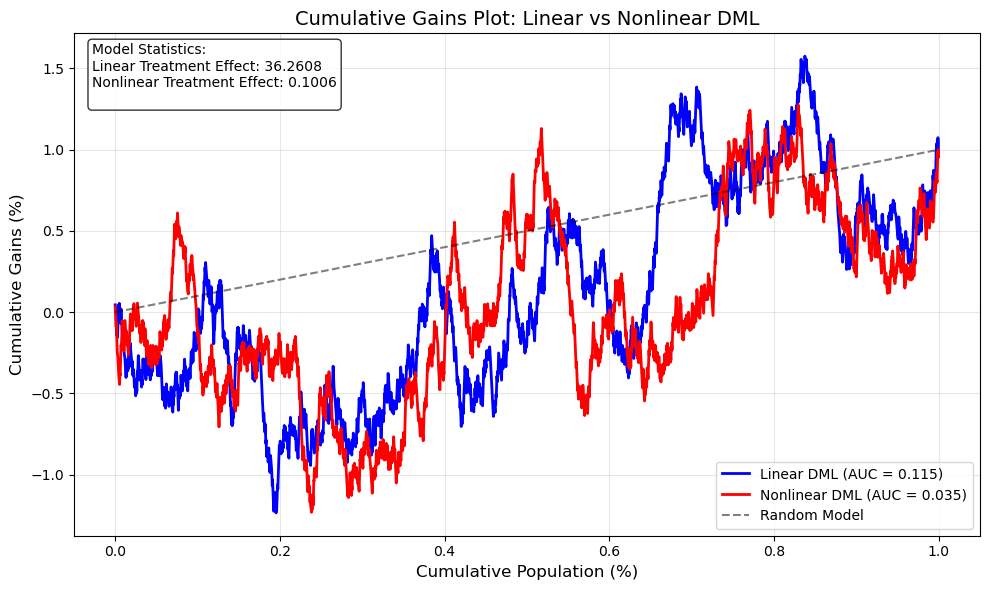


Detailed Model Comparison:
Linear DML:
- Treatment Effect: 36.2608
- AUC Score: 0.1150

Nonlinear DML:
- Treatment Effect: 0.1006
- AUC Score: 0.0348


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_cumulative_gains(y_true, y_pred_linear, y_pred_nonlinear):

    
   
    linear_sorted_indices = np.argsort(y_pred_linear)[::-1]  
    nonlinear_sorted_indices = np.argsort(y_pred_nonlinear)[::-1]  
    
 
    percentiles = np.arange(len(y_true)) / float(len(y_true))
    
    # Calculate cumulative gains
    linear_gains = np.cumsum(y_true[linear_sorted_indices]) / np.sum(y_true)
    nonlinear_gains = np.cumsum(y_true[nonlinear_sorted_indices]) / np.sum(y_true)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot lines
    plt.plot(percentiles, linear_gains, 'b-', 
             label=f'Linear DML (AUC = {auc(percentiles, linear_gains):.3f})', 
             linewidth=2)
    plt.plot(percentiles, nonlinear_gains, 'r-', 
             label=f'Nonlinear DML (AUC = {auc(percentiles, nonlinear_gains):.3f})', 
             linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Model', alpha=0.5)
    
    
    plt.title('Cumulative Gains Plot: Linear vs Nonlinear DML', fontsize=14)
    plt.xlabel('Cumulative Population (%)', fontsize=12)
    plt.ylabel('Cumulative Gains (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right', fontsize=10)
    
   
    stats_text = (
        f'Model Statistics:\n'
        f'Linear Treatment Effect: {treatment_effect_linear:.4f}\n'
        f'Nonlinear Treatment Effect: {treatment_effect_nonlinear:.4f}\n'
    )
    
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    print("\nDetailed Model Comparison:")
    print(f"Linear DML:")
    print(f"- Treatment Effect: {treatment_effect_linear:.4f}")
    print(f"- AUC Score: {auc(percentiles, linear_gains):.4f}")
    print(f"\nNonlinear DML:")
    print(f"- Treatment Effect: {treatment_effect_nonlinear:.4f}")
    print(f"- AUC Score: {auc(percentiles, nonlinear_gains):.4f}")

plot_cumulative_gains(
    outcome_residuals,  
    treatment_residuals * treatment_effect_linear,  # Linear predicted treatment effect
    treatment_residuals_non * treatment_effect_nonlinear  # Nonlinear predicted treatment effect
)


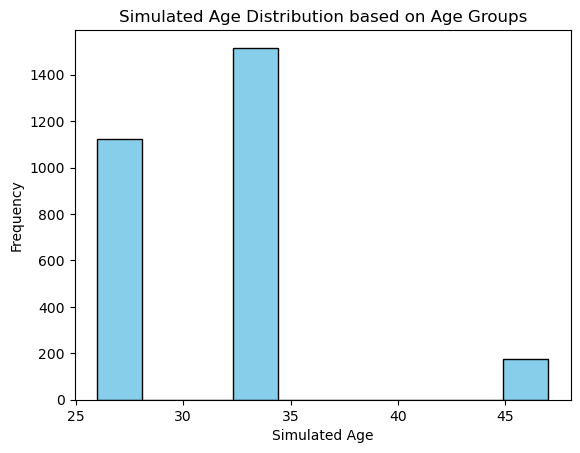

Estimated Treatment Effect based on Simulated 'Age': 0.1613
Intercept: 0.6260
Coefficients for 'simulated_age' and 'post_policy': [[-0.00481391  0.16125191]]


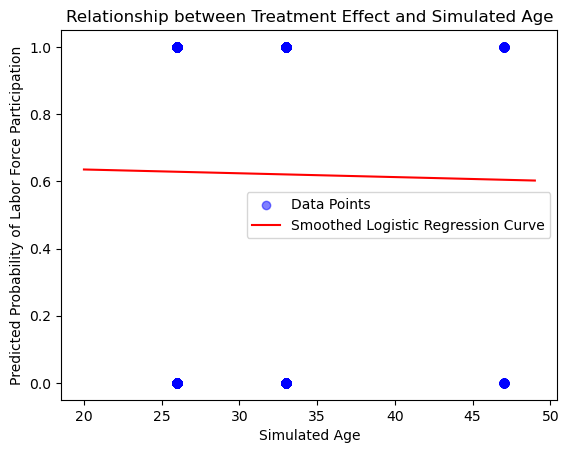

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Mapping 'age_group' to a numerical age range for simulation purposes
age_group_map = {
    '20s': (20, 29),
    '30s': (30, 39),
    '40s': (40, 49)
}

np.random.seed(42)

def simulate_age(group):
    min_age, max_age = age_group_map[group]
    return np.random.randint(min_age, max_age + 1)


unique_data['simulated_age'] = unique_data['age_group'].apply(simulate_age)

# Visualize the distribution of the simulated age variable
plt.hist(unique_data['simulated_age'], bins=10, color='skyblue', edgecolor='black')
plt.title("Simulated Age Distribution based on Age Groups")
plt.xlabel("Simulated Age")
plt.ylabel("Frequency")
plt.show()



# Extracting the treatment (post_policy) and outcome (rm_lfp) variables
treatment = unique_data['post_policy']
outcome = unique_data['rm_lfp']
simulated_age = unique_data['simulated_age']

# Fit a Logistic Regression model 
X = np.column_stack([simulated_age, treatment])
model = LogisticRegression(solver='liblinear').fit(X, outcome)

# Estimate the treatment effect
treatment_effect_simulated = model.coef_[0][1]  # The coefficient for the 'post_policy'

# Output the estimated treatment effect and model coefficients
print(f"Estimated Treatment Effect based on Simulated 'Age': {treatment_effect_simulated:.4f}")
print(f"Intercept: {model.intercept_[0]:.4f}")
print(f"Coefficients for 'simulated_age' and 'post_policy': {model.coef_}")


age_grid = np.linspace(20, 49, 500) 
X_grid = np.column_stack([age_grid, np.ones_like(age_grid) * treatment.mean()])  # Use the average treatment effect

predicted_probabilities_smooth = model.predict_proba(X_grid)[:, 1]

# Plotting the smoother logistic regression curve
plt.scatter(simulated_age, outcome, alpha=0.5, color='blue', label='Data Points')
plt.plot(age_grid, predicted_probabilities_smooth, color='red', label='Smoothed Logistic Regression Curve')
plt.title("Relationship between Treatment Effect and Simulated Age")
plt.xlabel("Simulated Age")
plt.ylabel("Predicted Probability of Labor Force Participation")
plt.legend()
plt.show()
